In [1]:
%run ./'01 load.ipynb'

In [44]:
len_predictions = 15
death_rate = 0.07944518504 # italy as of 2020-03-18
start_date = '2020-02-10'
len_before_start = len(df[(df['country'] == 'Germany') & (df['date'] < start_date)])
len_after_start = len(df[(df['country'] == 'Germany') & (df['date'] >= start_date)])

In [3]:
germany = df[df['country'] == 'Germany']
dates_new = pd.date_range(germany['date'].iloc[-1], periods=len_predictions)
df_new = pd.DataFrame(dates_new[1:], columns=['date'])
germany = germany.append(df_new, ignore_index=True)
germany['date_string'] = germany['date'].dt.strftime('%d. %b')

In [4]:
# prepare machine learning magic
y = germany.iloc[len_before_start:]['confirmed'].dropna()
x = list(range(len(y)))
# machine learning magic
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return c**x + d
popt, pcov = curve_fit(func, x, y)

/miniconda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [5]:
# get x values from predictor
predict = []
for i in range(len_after_start+len_predictions):
    predict.append(func(i, *popt))
germany = germany.join(pd.DataFrame(enumerate(predict, len_before_start), columns=['id', 'predict']).set_index('id'))    

In [47]:
# predict deaths based on prediction of cases and death rate (see top)
germany['predict_deaths'] = germany['predict'] * death_rate

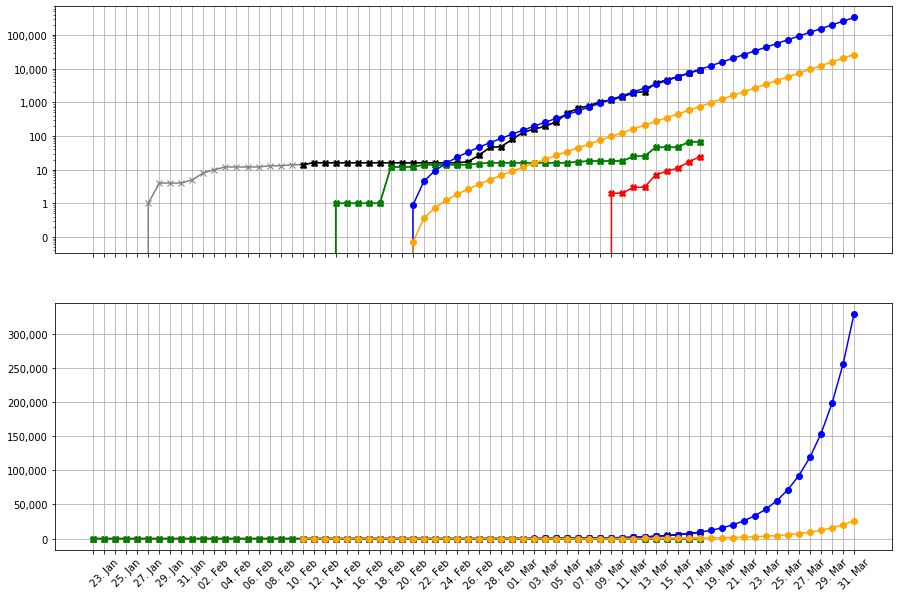

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker
format_y = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
x = list(germany['date_string'])
%matplotlib inline
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
ax1.grid(True)
ax1.plot(germany['date_string'], germany['confirmed'], marker='x', color='gray')
ax1.plot(germany['date_string'], germany['deaths'], marker='X', color='red')
ax1.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
ax1.plot(germany.iloc[len_before_start:]['date_string'], germany.iloc[len_before_start:]['confirmed'], marker='X', color='black')
ax1.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
ax1.plot(germany['date_string'], germany['predict'], marker='o', color='blue')
ax1.plot(germany['date_string'], germany['predict_deaths'], marker='o', color='orange')
ax1.set_xticklabels([])
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(format_y)
ax2 = fig.add_subplot(2,1,2)
ax2.grid(True)
ax2.plot(germany['date_string'], germany['confirmed'], marker='x', color='gray')
ax2.plot(germany['date_string'], germany['deaths'], marker='X', color='red')
ax2.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
ax2.plot(germany.iloc[len_before_start:]['date_string'], germany.iloc[len_before_start:]['confirmed'], marker='X', color='black')
ax2.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
ax2.plot(germany['date_string'], germany['predict'], marker='o', color='blue')
ax2.plot(germany['date_string'], germany['predict_deaths'], marker='o', color='orange')
ax2.set_xticklabels(labels=germany['date_string'], rotation=45)
ax2.yaxis.set_major_formatter(format_y)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

In [51]:
germany.iloc[-len_predictions-5:]

,country,date_string,confirmed,deaths,recovered,date,predict,predict_deaths
50,Germany,12. Mar,"2,078",3,25,2020-03-12,"2,623",208
51,Germany,13. Mar,"3,675",7,46,2020-03-13,"3,385",269
52,Germany,14. Mar,"4,585",9,46,2020-03-14,"4,368",347
53,Germany,15. Mar,"5,795",11,46,2020-03-15,"5,635",448
54,Germany,16. Mar,"7,272",17,67,2020-03-16,"7,269",577
55,Germany,17. Mar,"9,257",24,67,2020-03-17,"9,375",745
56,NaN,18. Mar,nan,nan,nan,2020-03-18,"12,091",961
57,NaN,19. Mar,nan,nan,nan,2020-03-19,"15,592","1,239"
58,NaN,20. Mar,nan,nan,nan,2020-03-20,"20,105","1,597"
59,NaN,21. Mar,nan,nan,nan,2020-03-21,"25,925","2,060"
